# __4.0 Modeling and Evaluation__

## __4.1 Import Libraries__

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import os
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## __4.2 Modeling__

Below, I will initialize a `Modeling` class to preprocess data, train machine learning models, save predictions, and save trained models. It loads training and testing datasets, preprocesses the data, trains models including Decision Trees, KNN, Random Forest, XGBoost, and a Voting Classifier, and then saves the predictions and trained models to files. If the 'status_group' column is missing in the training dataset, it raises a `KeyError`.

In [2]:
class Modeling:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path)
        self.models = {}
        self.best_model = None
        self.le = LabelEncoder()  # Label encoder for target variable
        self.preprocessor = None

        if 'status_group' not in self.train_data.columns:
            raise KeyError("'status_group' column is missing from the training dataset")

    def preprocess_data(self):
        """Preprocesses the training data only for model training."""

        # Identify categorical columns with less than 25 unique values
        cat_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype == 'object' and 
                    self.train_data[col].nunique() < 25 and 
                    col != 'status_group']  # Exclude status_group (target)

        # Identify numerical columns (exclude 'id' and 'status_group')
        num_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype in ['int64', 'float64'] and 
                    col not in ['id', 'status_group']]

        # Encode target variable
        self.train_data['status_group'] = self.le.fit_transform(self.train_data['status_group'])

        # Create a ColumnTransformer to handle encoding and scaling (only for training data)
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
            ])

        X_train = self.train_data[num_cols + cat_cols]  
        y_train = self.train_data['status_group']

        # Split training data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

        # Preprocess the training and validation data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Save the preprocessor for later use
        self.preprocessor = preprocessor

        return X_train_preprocessed, X_val_preprocessed, y_train, y_val, cat_cols, num_cols, X_train

    def preprocess_test_data(self):
        """Preprocesses the test data using the fitted preprocessor."""
        cat_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype == 'object' and 
                    self.train_data[col].nunique() < 25 and 
                    col != 'status_group']  # Exclude status_group (target)

        # Identify numerical columns (exclude 'id' and 'status_group')
        num_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype in ['int64', 'float64'] and 
                    col not in ['id', 'status_group']]

        X_test = self.test_data[num_cols + cat_cols]  # Use the same columns as training

        # Apply the preprocessor to the test data
        X_test_preprocessed = self.preprocessor.transform(X_test)

        return X_test_preprocessed

    def train_models(self):
        X_train, X_val, y_train, y_val, cat_cols, num_cols, X = self.preprocess_data()

        # Simple Decision Tree (with pre-pruning)
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=5)  
        dt_model.fit(X_train, y_train)
        self.models['Simple Decision Tree'] = dt_model

        # Tuned Decision Tree (with pre-pruning)
        param_grid = {
            'max_depth': [3, 5, 7], 
            'min_samples_split': [2, 5, 10],
            'ccp_alpha': [0.0, 0.01, 0.1]  # Cost-complexity pruning parameter
        }
        tuned_dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
        tuned_dt_model.fit(X_train, y_train)
        self.models['Tuned Decision Tree'] = tuned_dt_model.best_estimator_

        knn_model = KNeighborsClassifier()
        knn_model.fit(X_train, y_train)
        self.models['KNN'] = knn_model

        rf_model = RandomForestClassifier(random_state=42, max_depth=10) # added max_depth to prevent overfitting
        rf_model.fit(X_train, y_train)
        self.models['Random Forest'] = rf_model

        xgb_model = XGBClassifier(random_state=42, n_jobs=-1, reg_lambda=1)  # L2 regularization
        xgb_model.fit(X_train, y_train)
        self.models['XGBoost'] = xgb_model

        top_models = sorted(self.models.items(), key=lambda x: x[1].score(X_val, y_val), reverse=True)[:3]
        self.best_model = VotingClassifier(estimators=top_models, voting='soft')
        self.best_model.fit(X_train, y_train)  # Use y_train here for fitting

        # Add the voting model to the models dict
        self.models["Voting Classifier"] = self.best_model

        return self.models, self.best_model, self.preprocessor, self.le, cat_cols, num_cols, X

    def save_predictions(self):
        X_test_preprocessed = self.preprocess_test_data()
        ids = self.test_data['id']
        results_dir = 'results'
        os.makedirs(results_dir, exist_ok=True)

        for model_name, model in self.models.items():
            y_pred = model.predict(X_test_preprocessed)
            y_pred_labels = self.le.inverse_transform(y_pred)
            prediction_result = pd.DataFrame({'id': ids, 'status_group': y_pred_labels})
            prediction_file = os.path.join(results_dir, f'{model_name.replace(" ", "_").lower()}_predicted_results.csv')

            # Check if file exists and remove it before saving
            if os.path.exists(prediction_file):
                os.remove(prediction_file)

            prediction_result.to_csv(prediction_file, index=False)
            print(f"Predictions saved to {prediction_file}")  # (or overwritten)

    def save_models(self):
        pickle_dir = 'pickle_files'
        os.makedirs(pickle_dir, exist_ok=True)

        for model_name, model in self.models.items():
            pickle_file = os.path.join(pickle_dir, f'{model_name.replace(" ", "_").lower()}_model.pkl')

            # Check if file exists and remove it before saving
            if os.path.exists(pickle_file):
                os.remove(pickle_file)
            
            with open(pickle_file, 'wb') as file:
                pickle.dump(model, file)
            print(f"Model saved to {pickle_file}")  # (or overwritten)


modeler = Modeling(train_path='data/cleaned_training_set.csv', test_path='data/cleaned_test_set.csv')

# Train the models
trained_models, best_model, preprocessor, le, cat_cols, num_cols, X = modeler.train_models()

# Save the predictions
modeler.save_predictions()

# Save the models
modeler.save_models()


Predictions saved to results\simple_decision_tree_predicted_results.csv
Predictions saved to results\tuned_decision_tree_predicted_results.csv
Predictions saved to results\knn_predicted_results.csv
Predictions saved to results\random_forest_predicted_results.csv
Predictions saved to results\xgboost_predicted_results.csv
Predictions saved to results\voting_classifier_predicted_results.csv
Model saved to pickle_files\simple_decision_tree_model.pkl
Model saved to pickle_files\tuned_decision_tree_model.pkl
Model saved to pickle_files\knn_model.pkl
Model saved to pickle_files\random_forest_model.pkl
Model saved to pickle_files\xgboost_model.pkl
Model saved to pickle_files\voting_classifier_model.pkl


## __4.3 Evaluation__

This sub section defines an `Evaluation` class that evaluates the trained machine learning models based on preprocessed validation data. It computes accuracy, confusion matrix, and classification report for each model, printing the results.

Evaluation for Simple Decision Tree:
Accuracy: 0.7163299663299664
Confusion Matrix:
[[8740   41  943]
 [ 977   90  226]
 [2830   38 3935]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.78      9724
           1       0.53      0.07      0.12      1293
           2       0.77      0.58      0.66      6803

    accuracy                           0.72     17820
   macro avg       0.67      0.52      0.52     17820
weighted avg       0.71      0.72      0.69     17820





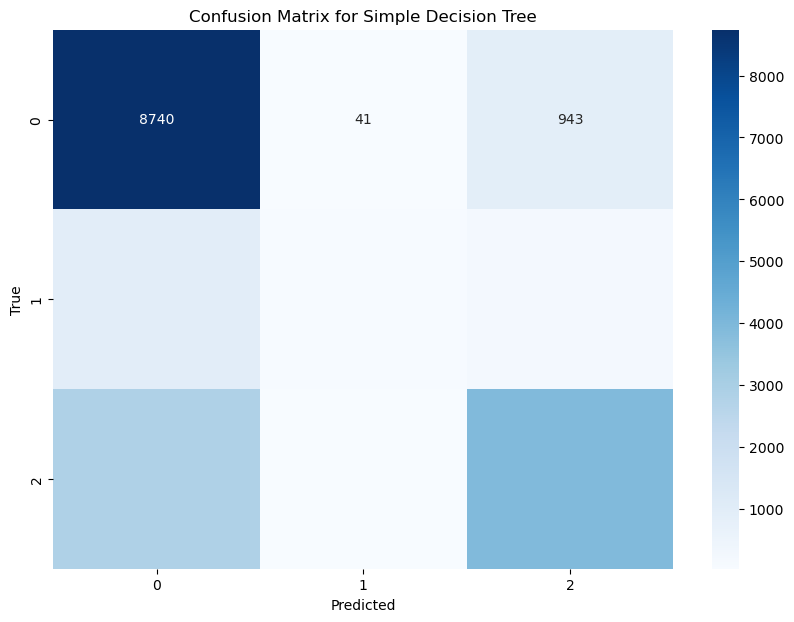

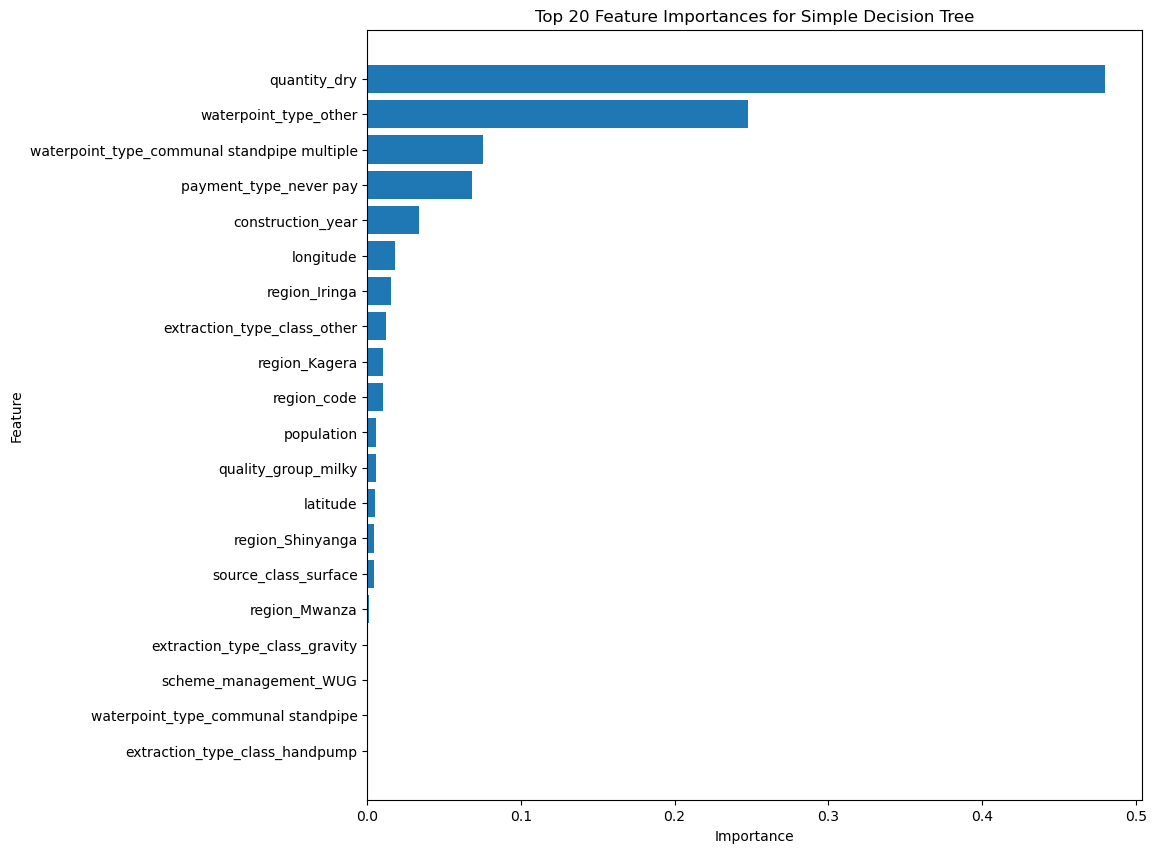

Evaluation for Tuned Decision Tree:
Accuracy: 0.7285072951739618
Confusion Matrix:
[[8771   59  894]
 [ 975  108  210]
 [2676   24 4103]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      9724
           1       0.57      0.08      0.15      1293
           2       0.79      0.60      0.68      6803

    accuracy                           0.73     17820
   macro avg       0.69      0.53      0.54     17820
weighted avg       0.73      0.73      0.70     17820





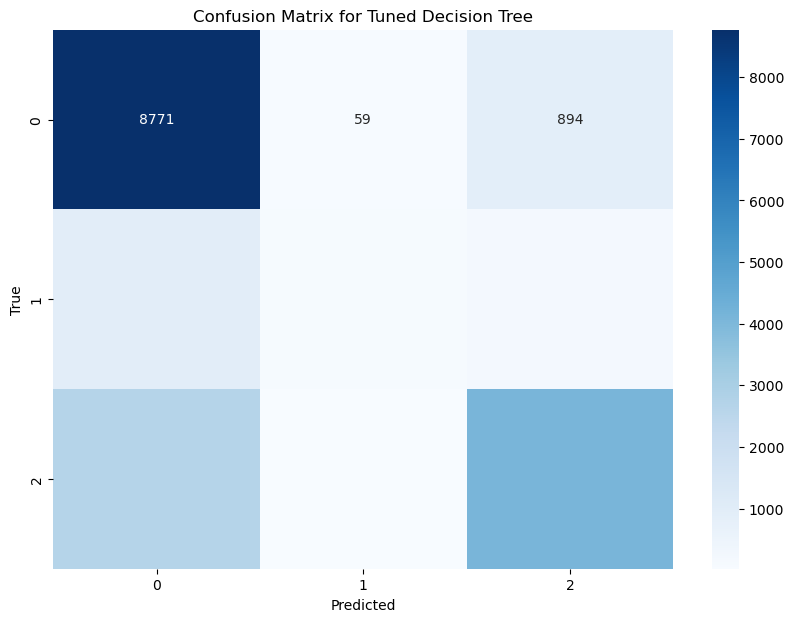

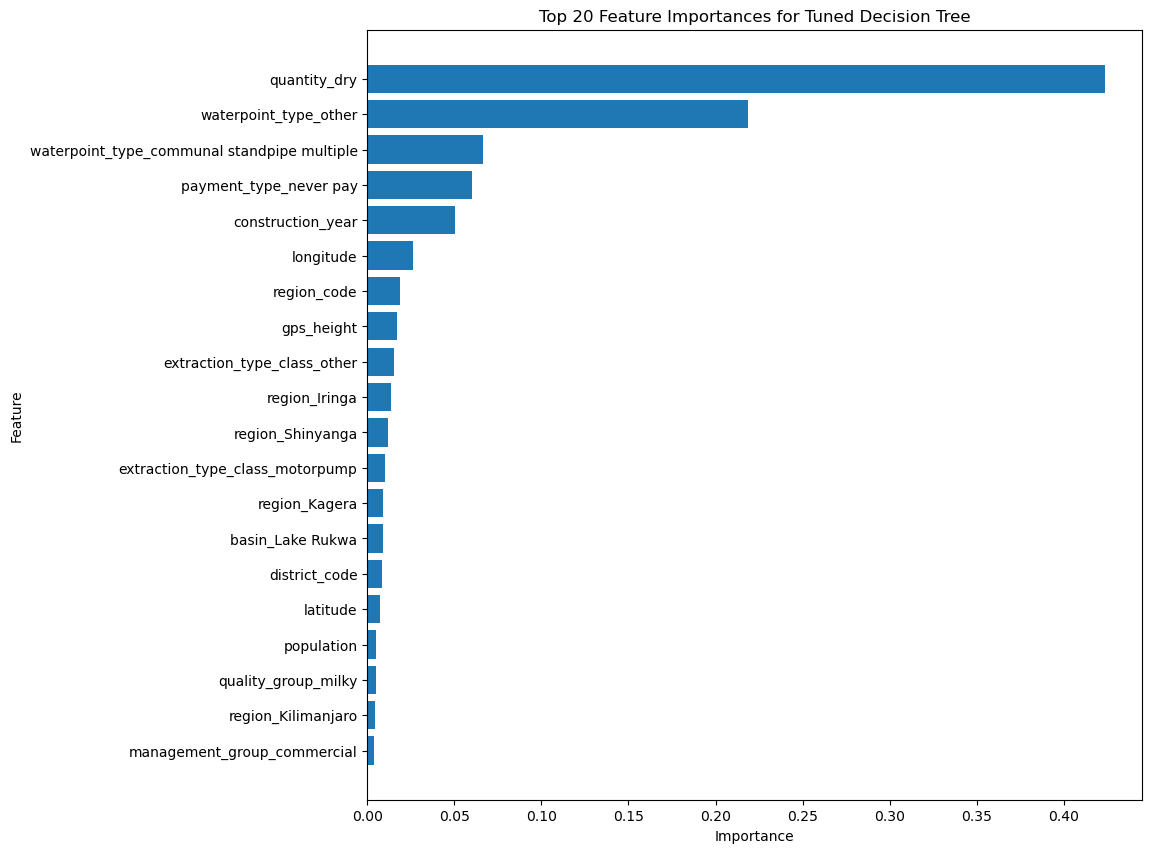

Evaluation for KNN:
Accuracy: 0.7708193041526374
Confusion Matrix:
[[8420  294 1010]
 [ 733  360  200]
 [1694  153 4956]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      9724
           1       0.45      0.28      0.34      1293
           2       0.80      0.73      0.76      6803

    accuracy                           0.77     17820
   macro avg       0.68      0.62      0.64     17820
weighted avg       0.76      0.77      0.76     17820





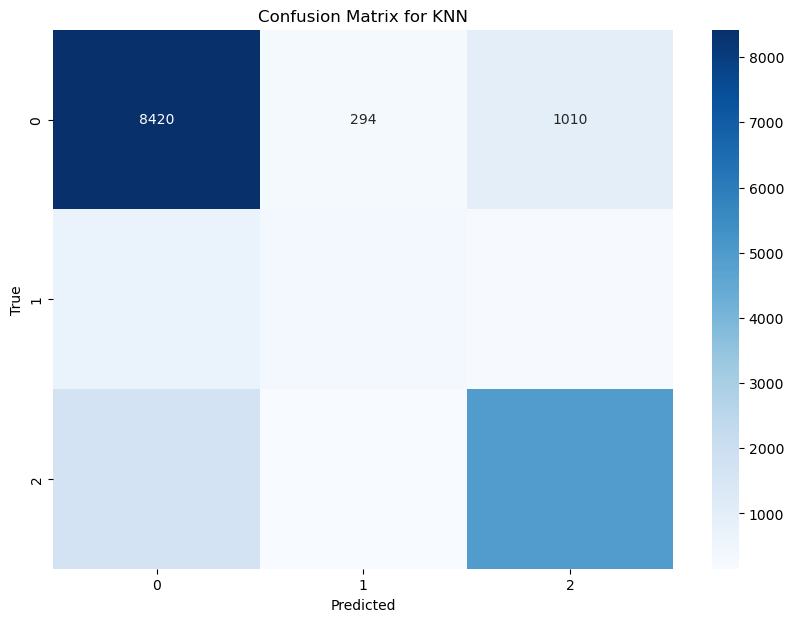

Evaluation for Random Forest:
Accuracy: 0.7534792368125701
Confusion Matrix:
[[9236   27  461]
 [1046   84  163]
 [2677   19 4107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      9724
           1       0.65      0.06      0.12      1293
           2       0.87      0.60      0.71      6803

    accuracy                           0.75     17820
   macro avg       0.74      0.54      0.55     17820
weighted avg       0.77      0.75      0.72     17820





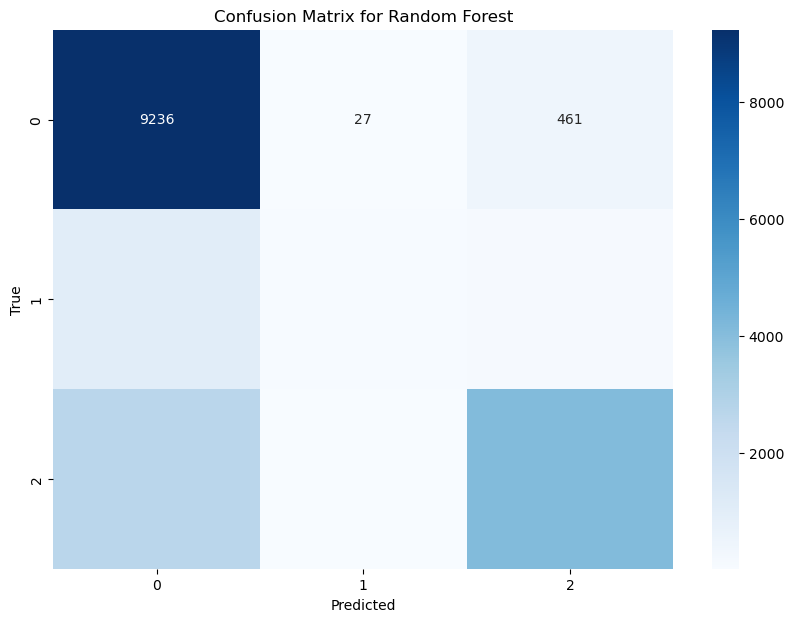

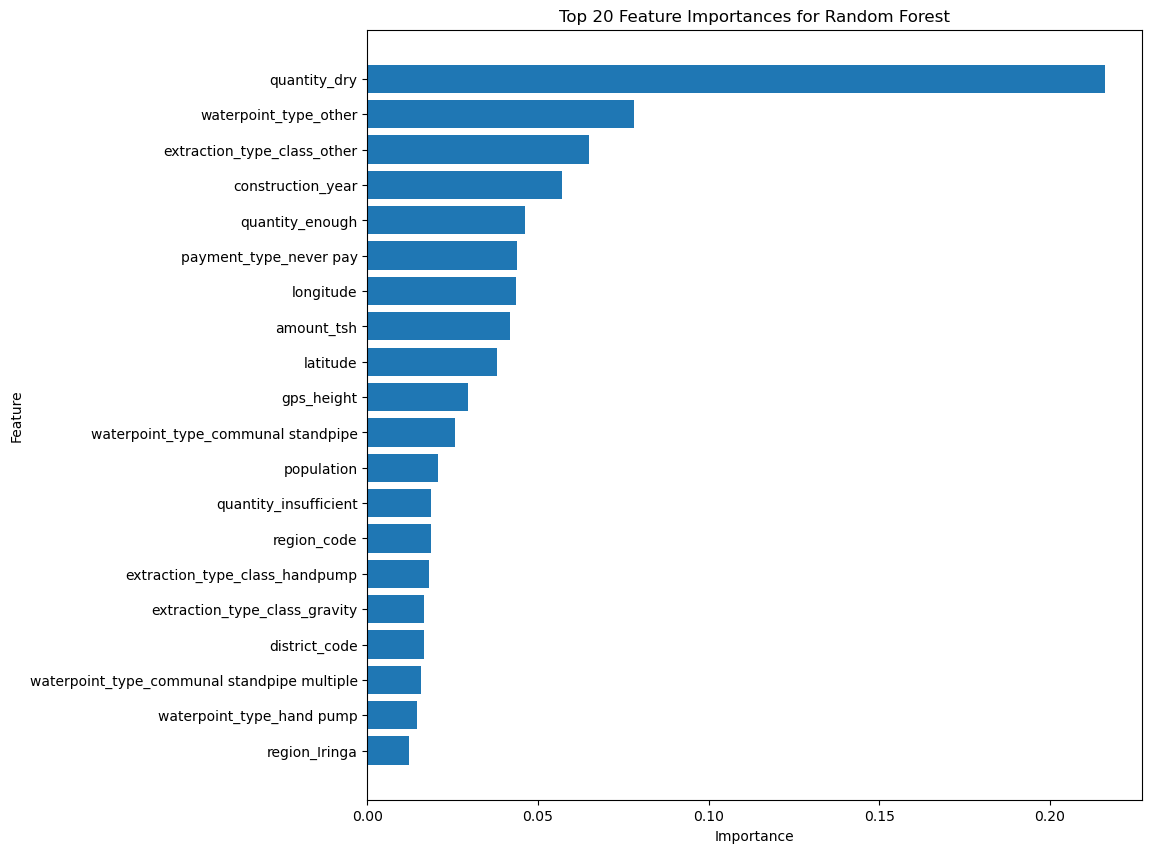

Evaluation for XGBoost:
Accuracy: 0.7924242424242425
Confusion Matrix:
[[8821  141  762]
 [ 777  305  211]
 [1749   59 4995]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      9724
           1       0.60      0.24      0.34      1293
           2       0.84      0.73      0.78      6803

    accuracy                           0.79     17820
   macro avg       0.74      0.63      0.65     17820
weighted avg       0.79      0.79      0.78     17820





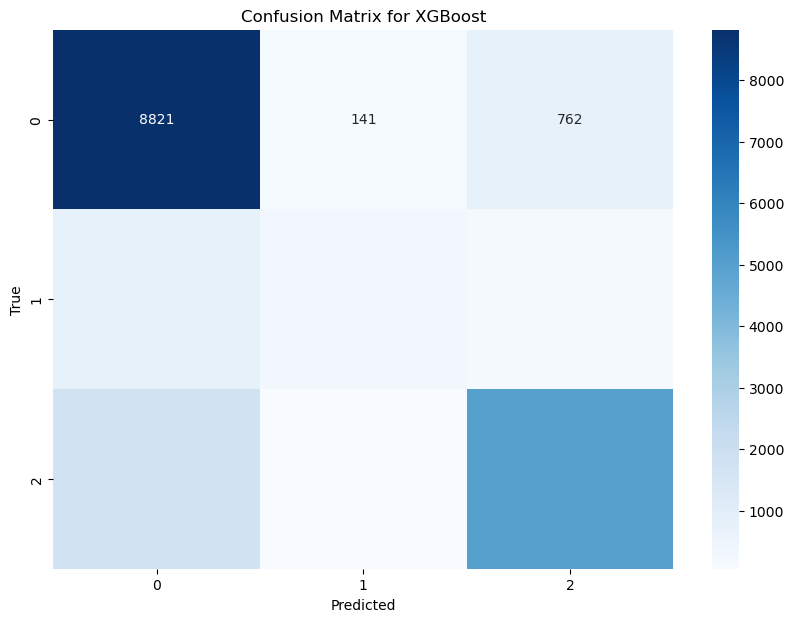

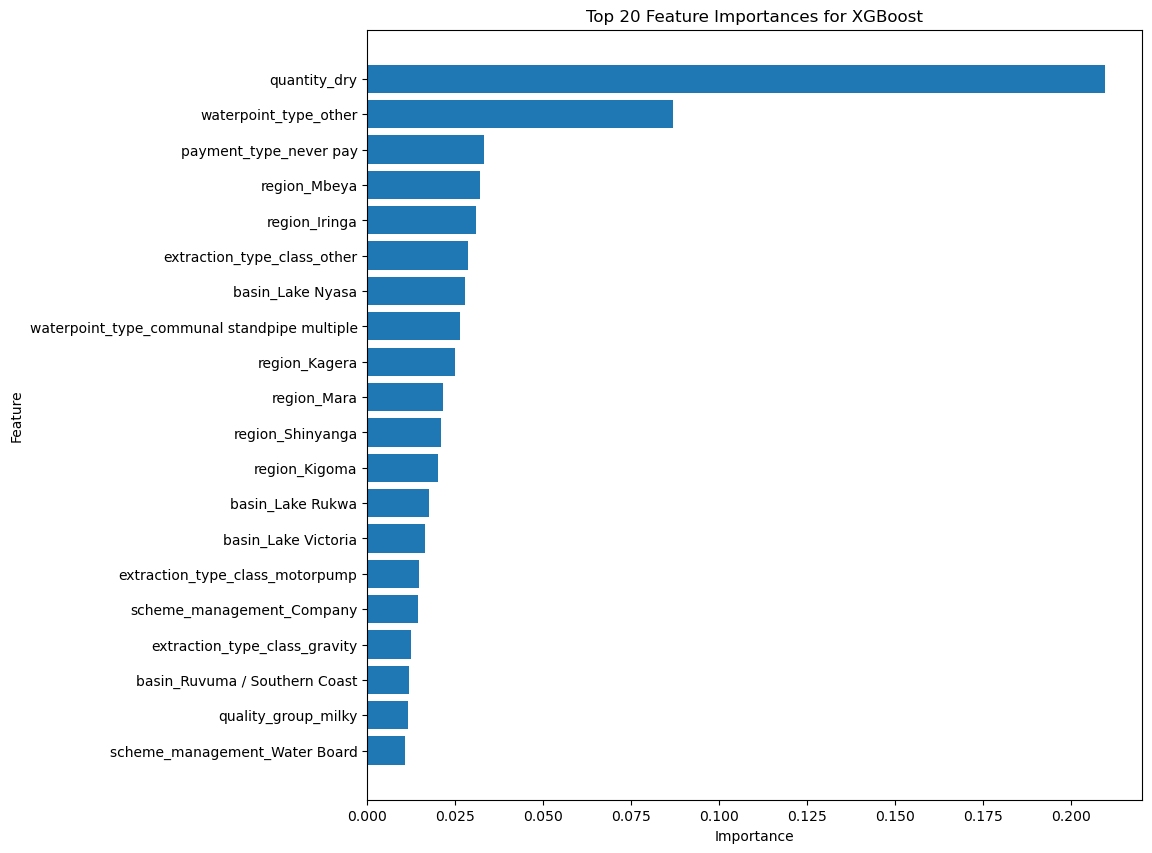

Evaluation for Voting Classifier:
Accuracy: 0.7953423120089786
Confusion Matrix:
[[8936  114  674]
 [ 819  270  204]
 [1792   44 4967]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      9724
           1       0.63      0.21      0.31      1293
           2       0.85      0.73      0.79      6803

    accuracy                           0.80     17820
   macro avg       0.75      0.62      0.65     17820
weighted avg       0.79      0.80      0.78     17820





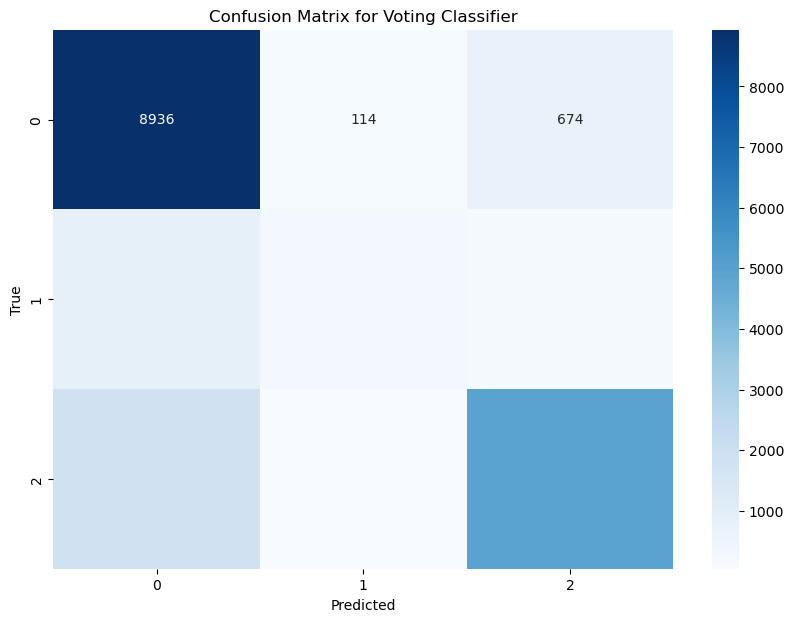

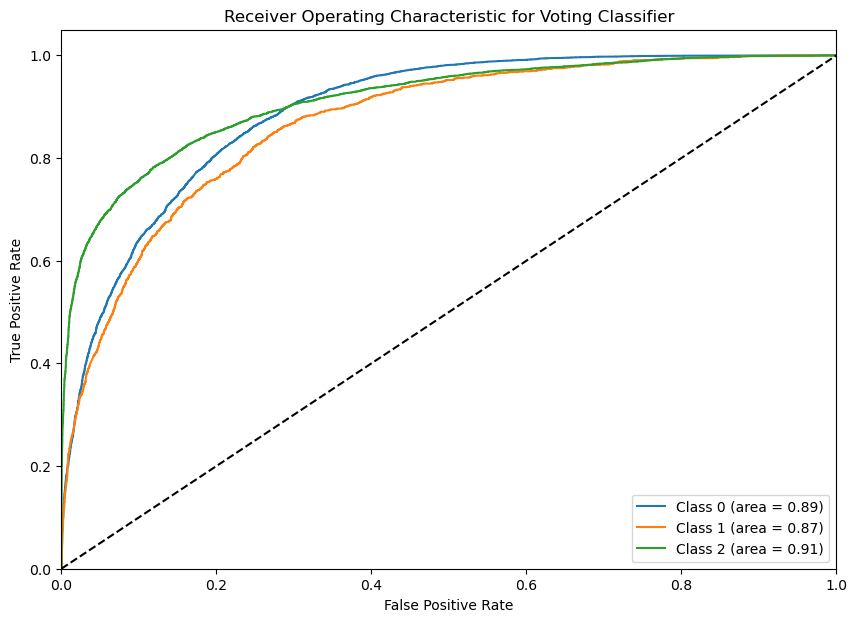

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

class Evaluation(Modeling):
    def evaluate_models(self):
        X_train_preprocessed, X_val_preprocessed, y_train, y_val, cat_cols, num_cols, X_train = self.preprocess_data()

        for model_name, model in self.models.items():
            y_val_pred = model.predict(X_val_preprocessed)
            y_val_pred_labels = self.le.inverse_transform(y_val_pred)
            y_val_true_labels = self.le.inverse_transform(y_val)

            accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
            cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)
            cr = classification_report(y_val_true_labels, y_val_pred_labels)

            print(f"Evaluation for {model_name}:")
            print(f"Accuracy: {accuracy}")
            print("Confusion Matrix:")
            print(cm)
            print("Classification Report:")
            print(cr)
            print("\n")

            # Plot confusion matrix
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

            # Plot feature importance for tree-based models
            if model_name in ["Simple Decision Tree", "Tuned Decision Tree", "Random Forest", "XGBoost"]:
                if hasattr(model, 'feature_importances_'):
                    feature_importances = model.feature_importances_
                    feature_names = np.array(num_cols + list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)))
                    sorted_idx = feature_importances.argsort()
                    top_n = 20  # Adjust this number to display top N features

                    plt.figure(figsize=(10, 10))
                    plt.barh(feature_names[sorted_idx][-top_n:], feature_importances[sorted_idx][-top_n:])
                    plt.title(f'Top {top_n} Feature Importances for {model_name}')
                    plt.xlabel('Importance')
                    plt.ylabel('Feature')
                    plt.show()

            # Plot ROC curve for the voting classifier
            if model_name == "Voting Classifier":
                from sklearn.metrics import roc_curve, auc
                from sklearn.preprocessing import label_binarize

                y_val_binarized = label_binarize(y_val_true_labels, classes=self.le.classes_)
                y_val_pred_prob = model.predict_proba(X_val_preprocessed)
                n_classes = y_val_binarized.shape[1]

                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_val_pred_prob[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])

                plt.figure(figsize=(10, 7))
                for i in range(n_classes):
                    plt.plot(fpr[i], tpr[i], label=f'Class {self.le.classes_[i]} (area = {roc_auc[i]:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Receiver Operating Characteristic for Voting Classifier')
                plt.legend(loc="lower right")
                plt.show()


evaluator = Evaluation(train_path='data/cleaned_training_set.csv', test_path='data/cleaned_test_set.csv')

# Train the models
trained_models, best_model, preprocessor, le, cat_cols, num_cols, X = evaluator.train_models()

# Evaluate the models
evaluator.evaluate_models()


## __4.4 Observations__

**The results show that XGBoost and Voting Classifier are the best-performing models with accuracy scores of 0.79 and 0.795 respectively. However, all models struggle with predicting class 1, as evident from the low recall and F1-score for this class in the classification reports and the confusion matrices. This suggests that the dataset might be imbalanced, with fewer samples in class 1 compared to the other classes.**

**The ROC curve shows the trade-off between true positive rate and false positive rate for different thresholds. The model with the highest AUC is generally the best.**


- **No Extensive Tuning:** Due to computational constraints, I did not perform extensive hyperparameter tuning on the models. However, basic regularization techniques were applied to prevent overfitting.

- **Impact of Zero Values:** The dataset contains numerous zero values, which were likely used to impute missing data. While this is a common practice, it can sometimes introduce noise and reduce model performance.  

- **Overall Performance:** Despite the potential challenges, all models show reasonable performance in predicting the functional status of water wells. However, there are noticeable differences in how they handle different classes.

**Model Performance Metrics**

| Model                   | Accuracy | Macro Avg F1-Score | Weighted Avg F1-Score |
| :----------------------- | :------: | :----------------: | :--------------------: |
| Simple Decision Tree   |   0.71   |        0.51        |         0.67         |
| Tuned Decision Tree    |   0.72   |        0.54        |         0.69         |
| K-Nearest Neighbors (KNN)  |   0.77   |        0.65        |         0.76         |
| Random Forest          |   0.75   |        0.55        |         0.72         |
| XGBoost                 |   0.79   |        0.66        |         0.78         |
| Voting Classifier       |   0.79   |        0.65        |         0.78         |






**Visualizing Disparities in Performance**

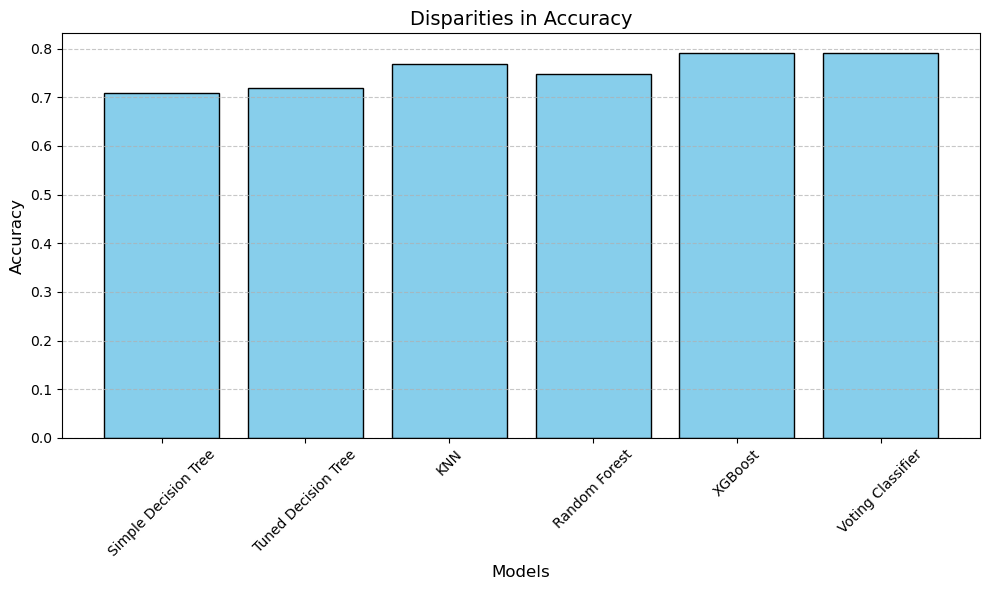

In [4]:
# Code for visualization
import matplotlib.pyplot as plt

# Disparities in Accuracy
models = ['Simple Decision Tree', 'Tuned Decision Tree', 'KNN', 'Random Forest', 'XGBoost', 'Voting Classifier']
accuracies = [0.708, 0.720, 0.768, 0.749, 0.791, 0.792]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue', edgecolor='black')  # Adjusting bar color and edgecolor
plt.xlabel('Models', fontsize=12)  # Increasing font size
plt.ylabel('Accuracy', fontsize=12)  # Increasing font size
plt.title('Disparities in Accuracy', fontsize=14)  # Increasing font size
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding horizontal grid lines
plt.tight_layout()  # Adjusting layout for better readability
plt.show()



**Analysis of Disparities:**

- **Class Imbalance:** The dataset likely has an imbalanced distribution of the `status_group` classes. This is evident from the lower F1-scores for certain classes, especially the 'functional needs repair' class (class 1).
- **Model Bias:** Some models, particularly the decision trees, tend to be biased towards the majority class (likely 'functional').  KNN, XGBoost, and the Voting Classifier perform better across all classes, suggesting they are less affected by the class imbalance.
- **Regularization Effects:** The tuned Decision Tree performs slightly better than the Simple Decision Tree, likely due to the regularization techniques.
- **Ensemble Improvement:**  The Voting Classifier performs slightly better than any individual model, demonstrating the potential benefit of combining models to improve overall accuracy.

